# Problema del viatjant de comerç

En aquesta pràctica es resol el problema del viatjant de comerç (TSP) utilitzant diferents algorismes de cerca local. El problema consisteix en trobar el camí més curt que passa per totes les ciutats sense repetir cap i torna al punt de partida. Aquest problema és un dels problemes més estudiats en la història de la intel·ligència artificial i és un dels problemes NP-complet més coneguts.

Començarem definint el problema (TSP) com una classe que hereta de la classe ProblemaBusquedaLocal. Aquesta classe abstracta defineix els mètodes que ha d'implementar un problema de cerca local.
 En aquest cas, els mètodes que hem d'implementar són estats_successors, funcio_avaluacio i es_solucio. El mètode estats_successors retorna una llista amb tots els estats successors de l'estat rebut com a paràmetre. El mètode funcio_avaluacio retorna un valor numèric que indica la qualitat de l'estat rebut com a paràmetre. El mètode es_solucio retorna True si l'estat rebut com a paràmetre és una solució del problema. 

## Definició del problema

In [8]:
import math
import random
random.seed(42)

In [9]:
class ProblemaBusquedaLocal(object):
    """Aquesta és la classe abstracta per a un problema de cerca local.
    Per a implementar un problema de cerca local, subclassejar aquesta classe i
    implementar els mètodes estats_successors, funcio_avaluacio i es_solucio.
    """

    def __init__(self, inicial=None, **kwds):
        self.__dict__.update(inicial=inicial, **kwds)

    def estats_successors(self, estat):    raise NotImplementedError

    def es_solucio(self, estat):           raise NotImplementedError

    def funcio_avaluacio(self, state):     return NotImplementedError

    def __repr__(self):
        return '{}({!r})'.format(
            type(self).__name__, self.inicial)

In [10]:
class TSP(ProblemaBusquedaLocal):
    def estats_successors(self, estat):
        successors = []
        for i in range(len(estat)):
            for j in range(i + 1, len(estat)):
                successor = estat.copy()
                successor[i], successor[j] = successor[j], successor[i]
                successors.append(successor)
        return successors

    def es_solucio(self, estat):
        return True

    def distancia(self, ciutat1, ciutat2):
        # Formula de la distancia euclidiana
        return math.sqrt((ciutat1[0] - ciutat2[0]) ** 2 + (ciutat1[1] - ciutat2[1]) ** 2)

    def funcio_avaluacio(self, estat):
        distancia = 0
        for i in range(len(estat)):
            ciutat1 = self.ciutats[estat[i]]
            ciutat2 = self.ciutats[estat[(i + 1) % len(estat)]]
            distancia += self.distancia(ciutat1, ciutat2)
        return distancia

    @classmethod
    def genera_estat_inicial(cls, ciutats):
        cami = list(range(len(ciutats)))
        random.shuffle(cami)
        return cami

Definim una funció per a dibuixar el camí que passa per totes les ciutats. Aquesta funció rep com a paràmetres el problema i la solució. La funció utilitza la llibreria matplotlib per a dibuixar el camí.

In [11]:
import matplotlib.pyplot as plt


def plot_tsp(problema, solucio):
    x = [ciutat[0] for ciutat in problema.ciutats]
    y = [ciutat[1] for ciutat in problema.ciutats]
    plt.scatter(x, y)
    for i in range(len(solucio)):
        ciutat1 = problema.ciutats[solucio[i]]
        ciutat2 = problema.ciutats[solucio[(i + 1) % len(solucio)]]
        plt.plot([ciutat1[0], ciutat2[0]], [ciutat1[1], ciutat2[1]], 'k-')
    plt.show()

Creem una instància del problema TSP amb 8 ciutats. Aquesta instància es la que utilitzarem per a provar els diferents algorismes de cerca local.

In [12]:
ciutats = [
    (random.randint(0, 1000), random.randint(0, 1000)) for _ in range(8)
]
print(TSP.genera_estat_inicial(ciutats))
tsp = TSP(inicial=TSP.genera_estat_inicial(ciutats), ciutats=ciutats)

[3, 2, 4, 1, 5, 7, 0, 6]


## Solució exacta

En primer lloc, implementarem l'algorisme de cerca en amplada (BFS). Aquest algorisme explora tots els estats successors d'un estat abans de continuar amb l'estat següent. Aquest algorisme no és adequat per a resoldre el problema TSP ja que el nombre d'estats successors és molt gran; així i tot l'utilitzarem per a entendre com funciona.

Per poder utilizar-lo en el nostre problema hem llevat la condició de sortida quan es trobe una solució, ja que el problema TSP no té una solució única; busquem la millor solució. De fet, tal com ho hem plantejat totes les solucions són vàlides, però no totes tenen la mateixa qualitat. 

Una vegada finalitze ens retornarà la millor solució, guarantida, però el cost computacional serà molt alt.

Tal com está plantejat sería equivalent al backtracking, però sense recursivitat.

In [13]:
def tsp_bfs(problema):
    cua = [problema.inicial]
    visitats = set()
    millor_estat = None
    millor_fitness = float('inf')
    while cua:
        estat = cua.pop(0)
        if problema.es_solucio(estat):
            if problema.funcio_avaluacio(estat) < millor_fitness:
                millor_estat = estat
                millor_fitness = problema.funcio_avaluacio(estat)
                print(f"Millor fitness: {millor_fitness}")
        if str(estat) not in visitats:
            visitats.add(str(estat))
            successors = problema.estats_successors(estat)
            for successor in successors:
                cua.append(successor)
                
    return millor_estat

In [14]:
#solucio = tsp_bfs(tsp)
#print(tsp.funcio_avaluacio(solucio))
#plot_tsp(tsp, solucio)

El nombre d'estats successors és molt gran, per la qual cosa no és possible explorar tot l'espai d'estats. Per aquest motiu, utilitzarem un algorisme de cerca local. Aquests algorismes exploren l'espai d'estats a partir d'un estat inicial i es mouen a un estat successor si aquest té una qualitat millor que l'estat actual. Aquests algorismes no garanteixen trobar la millor solució, però són molt més eficients que els algorismes de cerca en amplada.

## Cerca local

El cost del backtracking és molt alt, superant els 3 minuts per a 8 ciutats. Per a 30 o més ciutats el cost és prohibitiu. Per aquest motiu, utilitzarem un algorisme de cerca local. Aquests algorismes exploren l'espai d'estats a partir d'un estat inicial i es mouen a un estat successor si aquest té una qualitat millor que l'estat actual. Aquests algorismes no garanteixen trobar la millor solució, però són molt més eficients que els algorismes exactes.

En primer lloc, implementarem l'algorisme de cerca en ascens (Hill Climbing). Aquest algorisme explora l'espai d'estats a partir d'un estat inicial i es mou a l'estat successor amb millor qualitat. Aquest algorisme és molt eficient però no garanteix trobar la millor solució, ja que pot quedar atrapat en un òptim local.

In [15]:
def hill_climbing(problema, iteracions=10000):
    estat = problema.inicial
    fitness = problema.funcio_avaluacio(estat)

    for _ in range(iteracions):
        successors = problema.estats_successors(estat)
        if not successors:
            break
        successor = min(successors, key=problema.funcio_avaluacio)
        fitness_succ = problema.funcio_avaluacio(successor)
        if fitness_succ < fitness:
            print(f"{fitness} < {fitness_succ}")
            estat = successor
            fitness = fitness_succ
        else:
            break
    return estat

In [16]:
#solucio = hill_climbing(tsp)
#print(tsp.funcio_avaluacio(solucio))
#plot_tsp(tsp, solucio)

Una optimització que podem fer és no generar tots els successors d'un estat i triar el millor, sinó que podem anar modificant l'estat actual (`inline`) i veure si aquest té una qualitat millor que l'estat actual; si no es millor, revertim els canvis. 

In [17]:
def hill_climbing_inline(problema, iteracions=10000):
    estat = problema.inicial
    fitness = problema.funcio_avaluacio(estat)

    for _ in range(iteracions):
        millorat_iter = False
        for i in range(len(estat)):
            for j in range(len(estat)):
                if i != j:
                    estat[i], estat[j] = estat[j], estat[i]
                    fitness_succ = problema.funcio_avaluacio(estat)
                    if fitness_succ < fitness:
                        print(f"{fitness} < {fitness_succ}")
                        fitness = fitness_succ
                        millorat_iter = True
                    else:
                        estat[i], estat[j] = estat[j], estat[i]
        if not millorat_iter:
            break
    return estat

4741.0658758835825 < 4235.7284786736
4235.7284786736 < 4121.588373362046
4121.588373362046 < 4053.1192473585147
4053.1192473585147 < 3550.8760865887216
3550.8760865887216 < 3179.904050340157
3179.904050340157 < 2664.230931604599
2664.230931604599


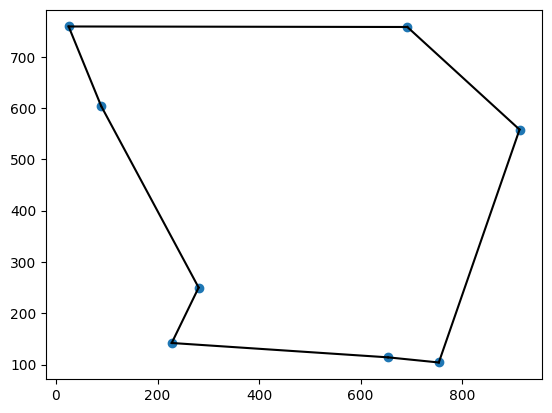

In [18]:
tsp = TSP(inicial=TSP.genera_estat_inicial(ciutats), ciutats=ciutats)
solucio = hill_climbing_inline(tsp)
print(tsp.funcio_avaluacio(solucio))
plot_tsp(tsp, solucio)

Quan el nombre de ciutats és gran, el cost de generar tots els successors d'un estat és molt alt. Per aquest motiu, utilitzarem un algorisme de cerca en primer millor (First Choice Hill Climbing). Aquest algorisme genera un estat successor aleatori i es mou a aquest si té una qualitat millor que l'estat actual. Aquest algorisme és molt més eficient que l'algorisme de cerca en ascens, ja que no genera tots els successors d'un estat. Les possibilitats de quedar atrapat en un òptim local, però, són més altes.

In [19]:
def first_choice_hill_climbing_inline(problema, iteracions=10000):
    estat = problema.inicial
    fitness = problema.funcio_avaluacio(estat)

    for _ in range(iteracions):
        millorat_iter = False
        for i in range(len(estat)):
            if not millorat_iter:
                for j in range(len(estat)):
                    if i != j:
                        estat[i], estat[j] = estat[j], estat[i]
                        fitness_succ = problema.funcio_avaluacio(estat)
                        if fitness_succ < fitness:
                            print(f"{fitness} < {fitness_succ}")
                            fitness = fitness_succ
                            millorat_iter = True
                            break
                        else:
                            estat[i], estat[j] = estat[j], estat[i]
    return estat

In [20]:
#solucio = first_choice_hill_climbing_inline(tsp)
#print(tsp.funcio_avaluacio(solucio))
#plot_tsp(tsp, solucio)

Una solució sencilla pero molt efectiva per a evitar quedar atrapat en un òptim local és generar un estat inicial aleatori i executar l'algorisme de cerca en primer millor un nombre determinat de vegades. Aquesta tècnica s'anomena random restart hill climbing.

In [21]:
def random_restart_hill_climbing(problema, ciutats, iteracions=1000, restarts=10):
    millor_estat = None
    millor_fitness = float('inf')
    for _ in range(restarts):
        inicial = TSP.genera_estat_inicial(ciutats)
        problema.inicial = inicial
        estat = first_choice_hill_climbing_inline(problema, iteracions=iteracions)
        fitness = problema.funcio_avaluacio(estat)
        if fitness < millor_fitness:
            millor_estat = estat
            millor_fitness = fitness
            print(f"Millor fitness: {millor_fitness}")
    print(f"Millor fitness Final: {millor_fitness}")
    return millor_estat

4292.928296572688 < 3256.4289032850124
3256.4289032850124 < 3218.4531937431548
3218.4531937431548 < 3204.4184298341343
3204.4184298341343 < 3179.8604639626437
3179.8604639626437 < 2786.6205022584872
2786.6205022584872 < 2664.2309316046
Millor fitness: 2664.2309316046
5397.682898065163 < 4819.476103916258
4819.476103916258 < 4217.4083323111645
4217.4083323111645 < 4147.551780095189
4147.551780095189 < 3218.4531937431548
3218.4531937431548 < 3179.9040503401575
3179.9040503401575 < 2664.2309316045994
Millor fitness: 2664.2309316045994
4489.66922948598 < 3463.140744355096
3463.140744355096 < 3340.7075873236945
3340.7075873236945 < 2845.056415461994
2845.056415461994 < 2714.073357448292
2714.073357448292 < 2664.2309316046
4455.824155456057 < 4433.606390279534
4433.606390279534 < 4213.98381164352
4213.98381164352 < 3913.9710453467505
3913.9710453467505 < 3482.711787723222
3482.711787723222 < 3481.7238581374204
3481.7238581374204 < 3359.3342874835325
3359.3342874835325 < 3343.1591775035567
33

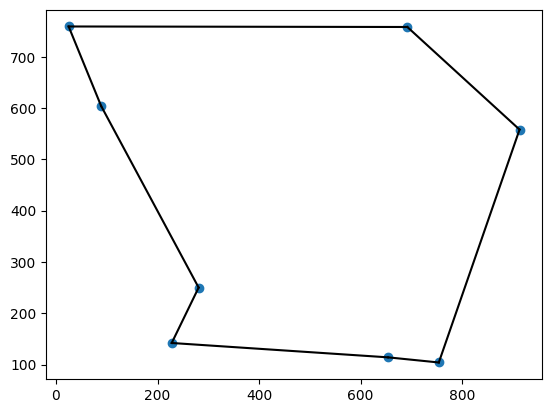

In [22]:
solucio = random_restart_hill_climbing(tsp, ciutats, 1000, 10)
print(tsp.funcio_avaluacio(solucio))
plot_tsp(tsp, solucio)

In [23]:
#%load_ext memory_profiler

## Cerca local estocàstica

Els algorismes de cerca local que hem vist fins ara sempre es mouen a un estat successor si aquest té una qualitat millor que l'estat actual. Aquesta estratègia pot fer que l'algorisme quede atrapat en un òptim local. Per aquest motiu, utilitzarem un algorisme de cerca local estocàstic. Aquests algorismes es mouen a un estat successor amb una qualitat pitjor que l'estat actual amb una certa probabilitat. Aquesta estratègia permet explorar l'espai d'estats i evitar quedar atrapat en un òptim local.

El més utilitzat és l'algorisme de recuit simulat (simulated annealing). Aquest algorisme es basa en el procés de refredament d'un metall. En aquest procés, el metall es refreda a poc a poc fins a arribar a l'estat sòlid. Aquest procés permet que les molècules del metall es moguin i així es pugui arribar a l'estat sòlid. Aquest algorisme es basa en la mateixa idea. En lloc de refredar un metall, refredem l'algorisme. Aquest procés permet que l'algorisme es mogui a estats successors amb una qualitat pitjor que l'estat actual. A mesura que l'algorisme es refreda, la probabilitat de moure's a un estat successor amb una qualitat pitjor que l'estat actual disminueix. Això permet que l'algorisme explore l'espai d'estats al principi i vagi a la recerca d'un òptim local a mesura que es refreda.

In [24]:
def simulated_annealing(problema, temp=100000, refredament=0.99999, iteracions=10000):
    estat = problema.inicial
    cost = problema.funcio_avaluacio(estat)

    while temp > 0.1:
        estat_candidat = random.choice(problema.estats_successors(estat))
        cost_nou = problema.funcio_avaluacio(estat_candidat)

        delta = cost_nou - cost
        if delta < 0:
            estat = estat_candidat
            cost = cost_nou
            print("Cost: ", cost)
        elif math.exp(-delta / temp) > random.uniform(0, 1):
            estat = estat_candidat
            cost = cost_nou

        temp = temp * refredament

    print("Cost final: ", cost)
    print("Estat final: ", estat)

    return estat

In [25]:
#solucio = simulated_annealing(tsp)
#plot_tsp(tsp, solucio)

In [26]:
def simulated_annealing_inline(problema, temp=100000, refredament=0.99999):
    estat = problema.inicial
    cost = problema.funcio_avaluacio(estat)

    while temp > 0.1:
        i = random.randint(1, len(estat) - 1)
        j = random.randint(1, len(estat) - 1)

        while i == j:
            j = random.randint(1, len(estat) - 1)

        estat[i], estat[j] = estat[j], estat[i]
        cost_nou = problema.funcio_avaluacio(estat)

        delta = cost_nou - cost
        if delta < 0:
            cost = cost_nou
            #print("Cost: ", cost_nou)
        elif math.exp(-delta / temp) > random.uniform(0, 1):
            cost = cost_nou
        else:
            estat[i], estat[j] = estat[j], estat[i]

        temp = temp * refredament

    print("Cost final: ", cost)
    print("Estat final: ", estat)

    return estat

Cost final:  2664.2309316045994
Estat final:  [5, 1, 7, 2, 3, 0, 4, 6]


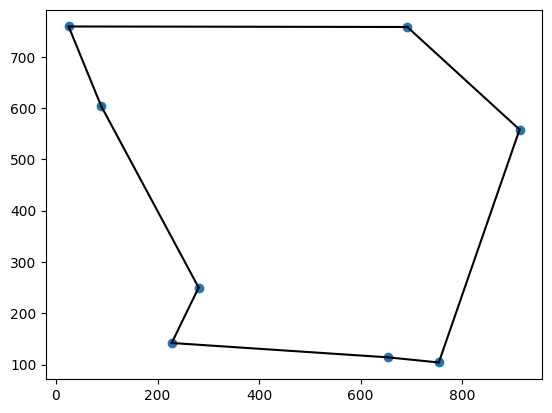

In [28]:
tsp = TSP(inicial=TSP.genera_estat_inicial(ciutats), ciutats=ciutats)
solucio = simulated_annealing_inline(tsp, temp=100, refredament=0.99)
plot_tsp(tsp, solucio)